In [1]:
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.applications.efficientnet_v2 import EfficientNetV2B3
from keras.applications.efficientnet_v2 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from keras.callbacks import ReduceLROnPlateau

This notebook builds a food classification model using EfficientNetV2. The dataset contains images of rice and fried rice. Let's break it down step by step.

# A. Dataset Exploration
This section initializes the DATASET variable as the root directory for the dataset. Subdirectories (rice and fried_rice) are defined separately to help organize the dataset by category. The `os.listdir` function is used to retrieve the list of image files in each directory, which are then counted to check for balance between categories. This step is crucial for ensuring fair training.

In [2]:
DATASET = './datasets'

# Just peek some datasets
rice_dir = os.path.join(DATASET, 'rice')
fried_rice_dir = os.path.join(DATASET, 'fried_rice')

rice_files = os.listdir(rice_dir)
fried_rice_files = os.listdir(fried_rice_dir)

print(f'COUNT => Rice: {len(rice_files)}; Fried Rice: {len(fried_rice_files)}')

COUNT => Rice: 1153; Fried Rice: 1100


## Samping Datasets
Samples 5 random images from each category and plots them for inspection. Random sampling ensures a diverse subset of images is displayed, allowing to verify that the dataset is correctly organized and contains meaningful content. The `random.sample` function picks images without replacement, ensuring that the same image does not appear twice in the same visualization. The use of `matplotlib` enables quick visual feedback to detect any issues such as corrupted images or incorrect labeling.

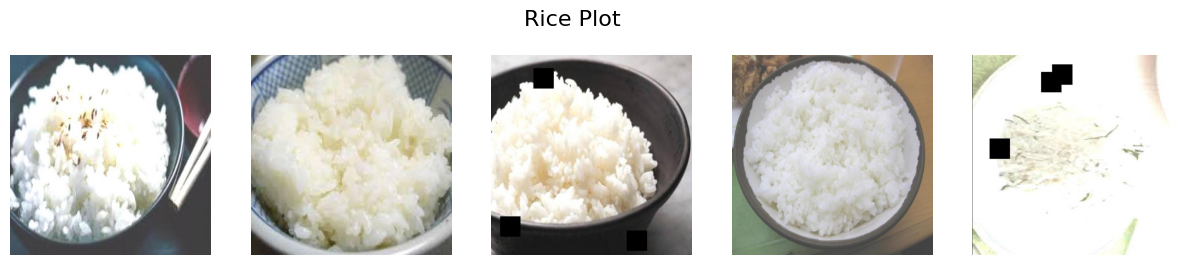

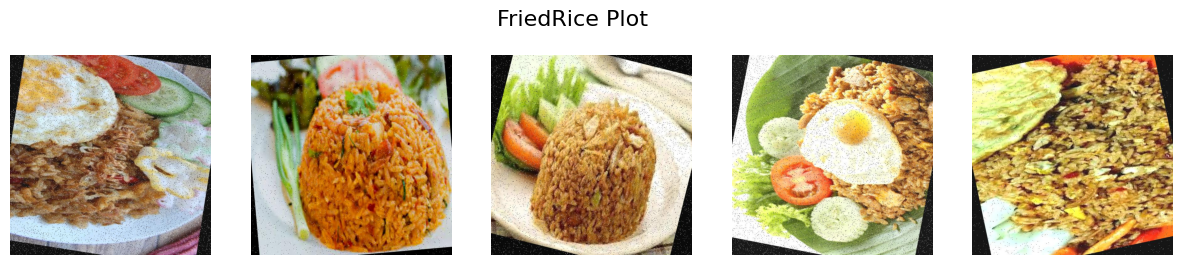

In [3]:
# Inspect
def inspect_dataset(category_name, category_dir, category_files):
    num_images = 5

    # Randomly sample images
    sampled_images = random.sample(category_files, k=num_images)
    image_paths = [os.path.join(category_dir, fname) for fname in sampled_images]
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f'{category_name} Plot', fontsize=16)
    
    # Display each image
    for ax, img_path in zip(axes, image_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
    
    plt.show()

inspect_dataset('Rice', rice_dir, rice_files)
inspect_dataset('FriedRice', fried_rice_dir, fried_rice_files)

## Splitting Datasets
This section splits the dataset into training and validation sets using a 90-10 ratio. The `image_dataset_from_directory` function:

- Automatically labels images based on their directory structure (e.g., rice and fried_rice).
- Scales images to a uniform size (image_size=(640, 640)) for consistent processing.
- Uses the validation_split parameter to separate a portion of data for validation, ensuring that the model is tested on unseen data during training.
- Leverages the subset argument to specify training or validation data. This is done in conjunction with the seed parameter to ensure reproducibility when splitting the dataset.

In [4]:
# Making the datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='datasets',
    image_size=(640, 640),
    label_mode='int',
    validation_split=.1,
    batch_size=16,
    subset='training',
    seed=42
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory='datasets',
    image_size=(640, 640),
    label_mode='int',
    validation_split=.1,
    batch_size=16,
    subset='validation',
    seed=42
)

Found 2792 files belonging to 4 classes.
Using 2513 files for training.
Found 2792 files belonging to 4 classes.
Using 279 files for validation.


In [5]:
# Data preprocessing so it can be more fit to NetEfficiency model
def preprocess(image, label):
    image = preprocess_input(image)

    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

In [6]:
# Optimize Datasets for training and validation for faster training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
val_dataset_final = val_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

# Get the first batch of images and labels
for images, labels in train_dataset_final.take(1):
    example_batch_images = images
    example_batch_labels = labels

print(f'Max pixels: {np.max(example_batch_images)}')
print(f'Shape of batch images: {example_batch_images.shape}; labels? {example_batch_labels.shape}')

Max pixels: 255.0
Shape of batch images: (16, 640, 640, 3); labels? (16,)


# B. Make Model
Building the model architecture, combining EfficientNetV2 as the base model with custom layers for classification. Key points:

- EfficientNetV2B3: A state-of-the-art pre-trained model for feature extraction, known for its efficiency and accuracy.
- Frozen Base Model: Setting `trainable = False` ensures that pre-trained weights are retained, avoiding overfitting on the small dataset.
- Custom Layers:
    - GlobalAveragePooling2D: Reduces the spatial dimensions of feature maps into a single value per filter, creating a compact feature representation.
    - Dropout: Adds regularization to prevent overfitting.
    - Dense: Fully connected layers for learning the relationship between features and output classes.
    - BatchNormalization: Normalizes activations to stabilize and speed up training.
-The model is compiled with the RMSprop optimizer, which is effective for large and sparse datasets, and a loss function suitable for multi-class classification (`sparse_categorical_crossentropy`).

In [7]:
# Using Transfer Learning and EfficientNetB7 as base model
pretrained_model = EfficientNetV2B3(
    input_shape=(640, 640, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = False

# Our custom layers on top
model = Sequential([
    Input(shape=(640, 640, 3)),
    pretrained_model,
    GlobalAveragePooling2D(),
    Dropout(.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(momentum=.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 20, 20, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

## Training Models
The training process involves the following components:
- EarlyStop Callback:
    - Monitors training (accuracy) and validation (val_accuracy) metrics.
    - Stops training when predefined thresholds are met, saving computational resources and preventing overfitting.

- ReduceLROnPlateau Callback:
    - Dynamically reduces the learning rate when the validation loss plateaus, allowing the model to fine-tune weights effectively.

- Model Training:
    - The fit function trains the model over a maximum of 10 epochs, evaluating its performance on the validation dataset at each epoch.
    - Training progress is logged, providing insight into accuracy and loss trends.

In [8]:
## Train ##
# Callbacks
class EarlyStop(tf.keras.callbacks.Callback):
    def __init__(self, accuracy_threshold, val_accuracy_threshold):
        self.accuracy_threshold = accuracy_threshold
        self.val_accuracy_threshold = val_accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.accuracy_threshold and val_acc >= self.val_accuracy_threshold:
                print(f"\nEpoch {epoch + 1}: accuracy reached {self.accuracy_threshold}, "
                      f"val_accuracy reached {self.val_accuracy_threshold}. Stopping training.")
                self.model.stop_training = True

early_stopping = EarlyStop(.95, .92)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)

# Train the model
epochs = 10
history = model.fit(
    train_dataset_final,
    validation_data=val_dataset_final,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-tuning
pretrained_model.trainable = True  # Unfreeze the base model

# Optionally, freeze earlier layers
for layer in pretrained_model.layers[:-20]:
    layer.trainable = False

# Recompile the model with a very low learning rate
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5, momentum=.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset_final,
    validation_data=val_dataset_final,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
158/158 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9574
Epoch 1: accuracy reached 0.95, val_accuracy reached 0.92. Stopping training.
158/158 [==============================] - 157s 812ms/step - loss: 0.1400 - accuracy: 0.9574 - val_loss: 0.0015 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 1/15
158/158 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9765
Epoch 1: accuracy reached 0.95, val_accuracy reached 0.92. Stopping training.
158/158 [==============================] - 110s 601ms/step - loss: 0.0783 - accuracy: 0.9765 - val_loss: 0.0041 - val_accuracy: 0.9964 - lr: 1.0000e-05


## Model Evaluate

18/18 [==============================] - 4s 241ms/step - loss: 0.0041 - accuracy: 0.9964
Validation loss: 0.004056061152368784
Validation accuracy: 0.9964157938957214


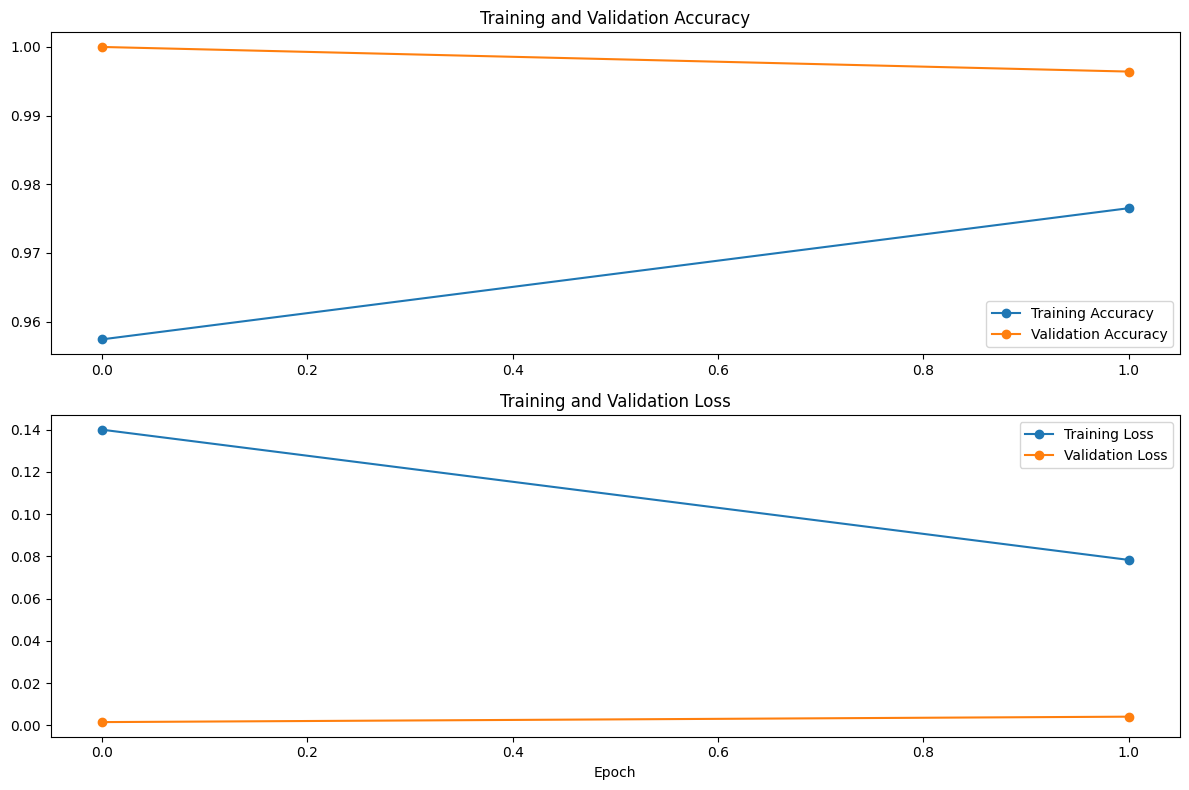

In [9]:
## Monitoring Training ##

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset_final)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

# Save the model
model.save('food_classification.h5')

# Combine history from initial training and fine-tuning
def combine_history(initial_history, fine_tune_history):
    acc = initial_history.history.get('accuracy', []) + fine_tune_history.history.get('accuracy', [])
    val_acc = initial_history.history.get('val_accuracy', []) + fine_tune_history.history.get('val_accuracy', [])
    loss = initial_history.history.get('loss', []) + fine_tune_history.history.get('loss', [])
    val_loss = initial_history.history.get('val_loss', []) + fine_tune_history.history.get('val_loss', [])
    return {'accuracy': acc, 'val_accuracy': val_acc, 'loss': loss, 'val_loss': val_loss}

combined_history = combine_history(history, history_fine)

# Save combined history to a .pkl file
with open('training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)

# Load history
# with open('training_history.pkl', 'rb') as f:
#     combined_history = pickle.load(f)

# Plotting the metrics
epochs_range = range(len(combined_history['accuracy']))

plt.figure(figsize=(12, 8))

# Plot Accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs_range, combined_history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(epochs_range, combined_history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(epochs_range, combined_history['loss'], label='Training Loss', marker='o')
plt.plot(epochs_range, combined_history['val_loss'], label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

The metrics for training and validation accuracy/loss are plotted over epochs to evaluate model performance and identify any overfitting or underfitting issues.

As we can see on the graphs. The graphs show high accuracy and low loss, indicating a well-trained model.